# Classification Workflow with Pipelines

Let's add pipelines into our workflow!

In [10]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer,  make_column_selector as selector
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import plot_confusion_matrix, recall_score,\
    accuracy_score, precision_score, f1_score

from sklearn.tree import DecisionTreeClassifier

from sklearn.dummy import DummyClassifier

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImPipeline

In [2]:
titanic = pd.read_csv('./data/titanic.csv')
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
X = titanic.drop(['PassengerId', 'Name', 'Survived'], axis=1)
y = titanic['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

## Using `Pipeline` and `ColumnTransformer`

When we use the `ColumnTransformer` we'll want to choose the relevant column numbers, so let's remind ourselves which columns are where:

In [5]:
X.head()

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,3,male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,female,35.0,1,0,113803,53.1000,C123,S
4,3,male,35.0,0,0,373450,8.0500,NaN,S


In [22]:
# We'll throw these mini-pipelines into our ColumnTransformer: numeric and categorical


subpipe_numerics = Pipeline(steps = [
    ('num_impute', SimpleImputer(strategy='median')),
    ('ss', StandardScaler())
])


subpipe_cat = Pipeline(steps=[
    ('cat_impute', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))
])

### Selector!!!!

[This](https://scikit-learn.org/stable/modules/generated/sklearn.compose.make_column_selector.html#sklearn.compose.make_column_selector) will return a callable list of columns

In [23]:
# Selector!

test = selector(dtype_include=object)
test(X)

['Sex', 'Ticket', 'Cabin', 'Embarked']

In [24]:
# The "remainder='passthrough'" bit tells the compiler to leave
# the other df columns unchanged.


CT = ColumnTransformer(transformers=[
    ('subpipe_num', subpipe_numerics, selector(dtype_include=np.number)),
    ('subpipe_cat', subpipe_cat, selector(dtype_include=object))
], remainder='passthrough')

## Bringing in Our Modeling Class from before

In [25]:
class ModelWithCV():
    '''Structure to save the model and more easily see its crossvalidation'''
    
    def __init__(self, model, model_name, X, y, cv_now=True):
        self.model = model
        self.name = model_name
        self.X = X
        self.y = y
        # For CV results
        self.cv_results = None
        self.cv_mean = None
        self.cv_median = None
        self.cv_std = None
        #
        if cv_now:
            self.cross_validate()
        
    def cross_validate(self, X=None, y=None, kfolds=10):
        '''
        Perform cross-validation and return results.
        
        Args: 
          X:
            Optional; Training data to perform CV on. Otherwise use X from object
          y:
            Optional; Training data to perform CV on. Otherwise use y from object
          kfolds:
            Optional; Number of folds for CV (default is 10)  
        '''
        
        cv_X = X if X else self.X
        cv_y = y if y else self.y

        self.cv_results = cross_val_score(self.model, cv_X, cv_y, cv=kfolds)
        self.cv_mean = np.mean(self.cv_results)
        self.cv_median = np.median(self.cv_results)
        self.cv_std = np.std(self.cv_results)

        
    def print_cv_summary(self):
        cv_summary = (
        f'''CV Results for `{self.name}` model:
            {self.cv_mean:.5f} ± {self.cv_std:.5f} accuracy
        ''')
        print(cv_summary)

        
    def plot_cv(self, ax):
        '''
        Plot the cross-validation values using the array of results and given 
        Axis for plotting.
        '''
        ax.set_title(f'CV Results for `{self.name}` Model')
        # Thinner violinplot with higher bw
        sns.violinplot(y=self.cv_results, ax=ax, bw=.4)
        sns.swarmplot(
                y=self.cv_results,
                color='orange',
                size=10,
                alpha= 0.8,
                ax=ax
        )

        return ax

In [26]:
# Create Dummy/Baseline


dummy_model_pipe = Pipeline(steps=[
    ('ct',CT),
    ('dummy', DummyClassifier(strategy='most_frequent'))
])

In [27]:
# Use the class with out dummy pipe

dummy_model_pipe.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001BCD7C4FFA0>),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                       

In [28]:
dummy_model_pipe.score(X_train, y_train)

0.6212574850299402

In [29]:
dummy_model_pipe.score(X_test, y_test)

0.600896860986547

<AxesSubplot:title={'center':'CV Results for `dummy` Model'}>

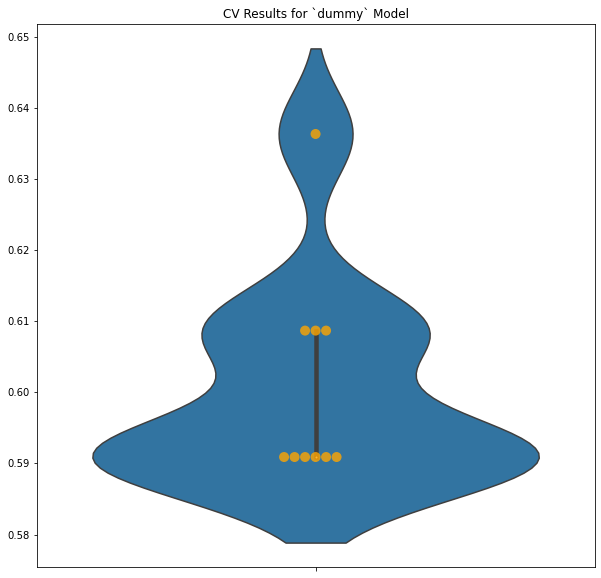

In [35]:
dummy_pipe = ModelWithCV(
    dummy_model_pipe,
    model_name='dummy',
    X=X_test,
    y=y_test)
fix, ax = plt.subplots(figsize=(10,10))

dummy_pipe.plot_cv(ax=ax)

In [30]:
# Create FSM (First Simple Model)

logreg_model_pipe = Pipeline(steps=[
    ('ct',CT),
    ('fsm', LogisticRegression())
])

In [31]:
# Use the class with out logreg pipe
logreg_model_pipe.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001BCD7C4FFA0>),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                       

<AxesSubplot:title={'center':'CV Results for `FSM` Model'}>

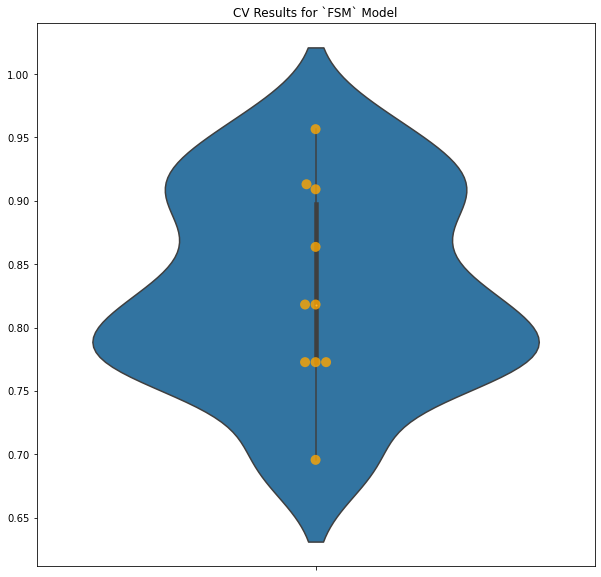

In [36]:
fsm_pipe = ModelWithCV(
    logreg_model_pipe,
    model_name='FSM',
    X=X_test,
    y=y_test)
fix, ax = plt.subplots(figsize=(10,10))

fsm_pipe.plot_cv(ax=ax)

In [41]:
dtc_model_pipe = Pipeline(steps=[
    ('ct', CT),
    ('dtc', DecisionTreeClassifier())
])

In [42]:
dtc_model_pipeline.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001BCD7C4FFA0>),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                       

<AxesSubplot:title={'center':'CV Results for `dtc` Model'}>

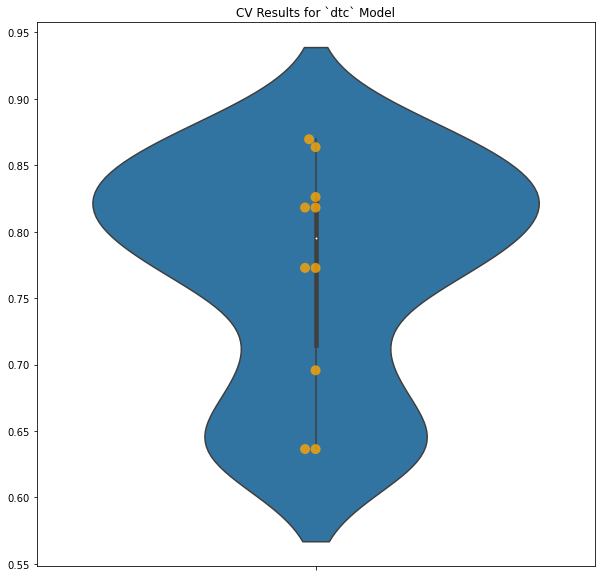

In [43]:
dtc_pipe = ModelWithCV(
    dtc_model_pipe,
    model_name='dtc',
    X=X_test,
    y=y_test)
fix, ax = plt.subplots(figsize=(10,10))

dtc_pipe.plot_cv(ax=ax)

In [49]:
dum_model = DummyClassifier(strategy='most_frequent')
lr_model = LogisticRegression()
tree_model = DecisionTreeClassifier()

In [50]:
model_list = [('dummy',dum_model), ('logreg',lr_model), ('dtc',tree_model)]

In [52]:
for name, model in model_list:
    loop_model_pipe = Pipeline(steps=[
        ('ct', CT),
        (name, model)
    ])
    
    loop_model_pipe.fit(X_train,y_train)
    
    loop_pipe = ModelWithCV(
        loop_model_pipe,
        model_name=name,
        X=X_test,
        y=y_test)
    
    loop_pipe.print_cv_summary()
    

CV Results for `dummy` model:
            0.60079 ± 0.01428 accuracy
        
CV Results for `logreg` model:
            0.82925 ± 0.07646 accuracy
        
CV Results for `dtc` model:
            0.79348 ± 0.08136 accuracy
        


## Trying Other Models at the End of the Pipeline

Can I have multiple models in a single pipeline? Yes. We'll forgo this here, but for more on this see [here](https://stackoverflow.com/questions/48507651/multiple-classification-models-in-a-scikit-pipeline-python).

### Random Forest

In [ ]:
# rfc!

### Gradient Booster

In [ ]:
# gbc!

## Tuning and Cross-Validating

In [54]:
dtc_model_pipe


Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001BCD7C4FFA0>),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                       

In [ ]:
DecisionTreeClassifier()

In [62]:
params = {}

params['ct__subpipe_num__num_impute__strategy'] = ['mean','median']
params['dtc__criterion'] = ['gini','entropy']
params['dtc__min_samples_leaf'] = [1, 5, 10]
params['dtc__max_depth'] = [1,2,3,4,5]

In [63]:
# GridSearch?

gs = GridSearchCV(estimator=dtc_model_pipe,
                 param_grid=params,
                 cv=10)

In [64]:
gs.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('subpipe_num',
                                                                         Pipeline(steps=[('num_impute',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('ss',
                                                                                          StandardScaler())]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x000001BCD7C4FFA0>),
                                                                        ('subpipe_cat',
                                                                         Pip

In [65]:
gs.best_params_

{'ct__subpipe_num__num_impute__strategy': 'median',
 'dtc__criterion': 'entropy',
 'dtc__max_depth': 4,
 'dtc__min_samples_leaf': 1}

In [68]:
gs.best_estimator_

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001BCD813B490>),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                       

In [ ]:
# Mean test score for each of six models

<AxesSubplot:title={'center':'CV Results for `gs` Model'}>

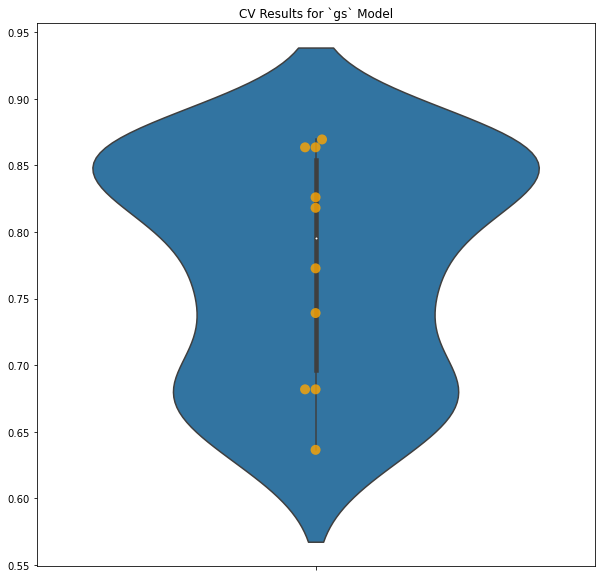

In [70]:
gs_pipe = ModelWithCV(
    gs.best_estimator_,
    model_name='gs',
    X=X_test,
    y=y_test)
fix, ax = plt.subplots(figsize=(10,10))

gs_pipe.plot_cv(ax=ax)

## `imblearn` Pipelines

### Dealing with the Target Imbalance

Let's use `SMOTE()`:

In [71]:
y_train.value_counts()

0    415
1    253
Name: Survived, dtype: int64

In [72]:
sm = SMOTE(sampling_strategy='auto', random_state=42)

In [73]:
sm2 = SMOTE(sampling_strategy=0.8, random_state=42)

To make things simple (and avoid errors!), let's just grab the numeric types and eliminate the NaNs from X_train:

In [74]:
X_train_clean = X_train.select_dtypes(['float', 'int']).dropna()
y_train_clean = y_train[X_train_clean.index]

In [75]:
y_train_clean.value_counts()

0    317
1    219
Name: Survived, dtype: int64

In [ ]:
sm.

In [76]:
# Even distribution

X_clean_resmp, y_clean_resmp = sm.fit_resample(X_train_clean, y_train_clean)

y_clean_resmp.value_counts()

1    317
0    317
Name: Survived, dtype: int64

In [77]:
# Distribution where count of 1's = 0.8 * count of 0's

X_clean_resmp2, y_clean_resmp2 = sm2.fit_resample(X_train_clean, y_train_clean)

y_clean_resmp2.value_counts()

0    317
1    253
Name: Survived, dtype: int64

### `imblearn` Pipeline

Of course, we want to be able to perform all of our preprocessing steps from above, but just now add `SMOTE`. Good thing we can throw it all into a pipeline!

In [82]:
def grab_numeric(df):
    return df.select_dtypes(include=['float','int'])

In [83]:
GrabNumeric = FunctionTransformer(grab_numeric)

In [84]:
pipe = Pipeline(steps=[
    ('num',GrabNumeric),
    ('ss', StandardScaler())
])

In [85]:
pipe.fit(X_train)

Pipeline(steps=[('num',
                 FunctionTransformer(func=<function grab_numeric at 0x000001BCDA5BB550>)),
                ('ss', StandardScaler())])

In [86]:
pipe.transform(X_test)

array([[            nan, -3.28390858e-01],
       [ 1.08779451e-01, -4.20425490e-01],
       [-6.49190250e-01, -4.70362102e-01],
       [-1.61387896e+00,  1.59138442e-02],
       [-1.06262827e+00, -4.06041806e-01],
       [-2.35752232e-01,  9.05076442e-01],
       [            nan, -4.73755853e-01],
       [-9.24815596e-01, -2.74979045e-01],
       [-9.24815596e-01, -4.73755853e-01],
       [-7.18096587e-01, -1.14342174e-01],
       [ 5.22217470e-01,  4.05710316e-01],
       [ 1.00456183e+00, -4.67937995e-01],
       [            nan, -1.30178383e-01],
       [ 3.98731144e-02, -4.83937104e-01],
       [ 4.53311133e-01, -3.71943341e-01],
       [-9.24815596e-01,  1.40028144e-01],
       [ 8.66749152e-01,  3.95125693e-01],
       [            nan, -4.72219938e-01],
       [-1.66845895e-01, -3.71943341e-01],
       [ 1.21128083e+00,  3.84378170e-01],
       [-3.73564904e-01, -4.70928374e-01],
       [ 3.15498460e-01, -1.09170098e-01],
       [-7.18096587e-01, -4.71735117e-01],
       [-6.

In [87]:
# imbpipe!

imb_pipe = ImPipeline(steps=[
    ('ct',CT),
    ('sm',SMOTE(random_state=42)),
    ('dtc',DecisionTreeClassifier(random_state=42))
])

In [88]:
imb_pipe.fit(X_train,y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001BCD7C4FFA0>),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                       

In [89]:
imb_pipe.score(X_train,y_train)

0.9985029940119761

In [90]:
imb_pipe.score(X_test,y_test)

0.7757847533632287

### Gridsearching

In [91]:
# Seriously? Again?
parameters = {'dtc__criterion': ['gini', 'entropy'],
          'dtc__min_samples_leaf': [1, 5, 10],
          'sm__k_neighbors': [3, 5, 9]}

gs = GridSearchCV(estimator=imb_pipe,
                 param_grid=parameters,
                 cv=10)

In [94]:
gs.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('subpipe_num',
                                                                         Pipeline(steps=[('num_impute',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('ss',
                                                                                          StandardScaler())]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x000001BCD7C4FFA0>),
                                                                        ('subpipe_cat',
                                                                         Pip

In [96]:
gs.best_params_

{'dtc__criterion': 'gini', 'dtc__min_samples_leaf': 1, 'sm__k_neighbors': 3}

In [97]:
final_model = gs.best_estimator_

## Evaluation on Test Set

Let's suppose that we choose our final model from this last GridSearch run. Note that the optimal parameters are also the default values!

In [92]:
# final_model = imb_pipe

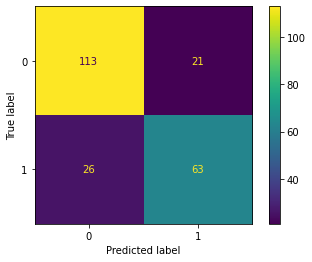

In [98]:
plot_confusion_matrix(final_model, X_test, y_test);

In [99]:
y_hat = final_model.predict(X_test)

In [100]:
print(f"""
Our final model's accuracy on the test set is {round(accuracy_score(y_test, y_hat), 2)}. \n
Our final model's recall on the test set is {round(recall_score(y_test, y_hat), 2)} \n
Our final model's precision on the test set is {round(precision_score(y_test, y_hat), 2)} \n
Our final model's f1-score on the test is {round(f1_score(y_test, y_hat), 2)}.
""")


Our final model's accuracy on the test set is 0.79. 

Our final model's recall on the test set is 0.71 

Our final model's precision on the test set is 0.75 

Our final model's f1-score on the test is 0.73.



## Exercise: Your Turn!

Use SMOTE and an estimator (model) of your choice in a pipeline to model the exoplanets' method of discovery ("method"). You can build a model one feature at a time or just throw them all in from the beginning. Consider using the LabelEncoder (from sklearn.preprocessing) to code up the target. You'll also need to make a choice about how to handle the null values.

In [ ]:
exos = sns.load_dataset('planets')

In [ ]:
### Your work here






